# Make More

- make more (as the name suggests) makes more of the things we give it
- it is a character-level language model 
    - meaning it will read the example character by character and try to predict the next character
- for example, if we train it on names, it will generate more name-like words 
    - it will read every line (name) as an example, treats each example as a sequence of characters

# Architectures 

- we will build a lot of architectures of character-level language models
    - Bi-gram (one character simply predicts a next one with a lookup table of counts)
    - MLP (Multi-Layer Perceptron), following [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), Bengio et al. 2003
    - RNNs (Recurrent Neural Networks), following [Recurrent Neural Network Based Language Model](https://www.fit.vut.cz/research/group/speech/public/publi/2010/mikolov_interspeech2010_IS100722.pdf), Mikolov et al. 2010
    - GRUs (Gated Recurrent Units), following [On the Properties of Neural Machine Translation: Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259), Cho et al. 2014
    - Transformers (the Equivalent of GPT-2), following [Attention is All You Need](https://arxiv.org/abs/1706.03762), Vaswani et al. 2017

after that we will understand how it works on the level of characters 

# Future plan
- after characters, we will spend some time on the word level (to generate documents of words)
- then go to images (image-text networks) like DALL-E and stable diffusion

In [1]:
import torch
import matplotlib.pyplot as plt

# Read the dataset

In [2]:
words = open("makemore/names.txt", "r").read().splitlines() # open the txt file and read in everything into a massive string, then split the individual words to a list

In [3]:
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
# number of examples
len(words)

32033

In [5]:
# shortest word
min(len(word) for word in words), min(words, key=len)

(2, 'an')

In [6]:
# longest word
max(len(word) for word in words), max(words, key=len)

(15, 'muhammadibrahim')

## Intuition
- what does a character-level language model models? for every single word like "isabella" is actually quite few examples packed in that single word or example 
    - it says that the character "i" is a very likely character to come first in the sequence of a name 
    - the character "s" is a very likely character to come after "i"
    - the character "a" is a very likely character to come after "is"
    - the character "b" is a very likely character to come after "isa"
    - and so on all the way to "a" following "isabell" 
    - finally, after there is isabella, the word is very likely to end
- so, as we can see, there is a lot of information packed into an individual word in terms of statistical structure of what is likely to follow some sequence of characters, that is what the language model is trying to capture not just for this example but for all the examples in the dataset

# 1- Bi-gram Language model
- will always work with just 2 characters at a time
    - meaning it will only look at one character, and try to predict the next character in the sequence
    - for example, what character is likely to come after "i"? what character is likely to come after "s"? and so on
- it will just model that local structure of 2-character window, and we forget the fact that we may have a lot more information 
    - so it is a very simple and weak language model
- mine: so it will model for each character, what is the character that is likely to come after it (it will learn that from all the examples in the dataset)
- for example it will learn from the word "isabella" that
    - "i" is likely to start a word
    - "s" is likely to come after "i"
    - "a" is likely to come after "s"
    - "b" is likely to come after "a"
    - and so on till "a" is likely to come after "l", and "a" is likely to finish the word

## 1-a intuitive approach to Bi-gram
- we will store the counts of each pair of characters, and then normalize them to get the probability distributions

In [7]:
# let's look at the bigrams in the dataset (bigrams are pairs of characters)
for w in words[:1]:
    # preprocess the word by attaching a <S> character in the beginning and <E> in the end of each word
    chs = ["<S>"] + list(w) + ["<E>"]
    # iterate on the consecutive letters of the above list 
    for ch1, ch2 in zip(chs,chs[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


- tip on Zip
    - zip is a function that takes two iterables and zips them together, and upon iteration, it will return a tuple of the elements of the two iterables each time
    - when any of the iterables is shorter than the other, zip will stop when the shorter one ends (and this agrees with what we want , as there is never a character after `<E>`) 

In [8]:
chs, chs[1:]

(['<S>', 'e', 'm', 'm', 'a', '<E>'], ['e', 'm', 'm', 'a', '<E>'])

- to learn the statistics about which characters are likely to follow other characters
    - the simplist way is to count the occurences of different combinations of consecutive characters in the dataset
    - therefore, we need a dictionary to maintain these counts for these bi-grams
        - the key will be the tuple of the two characters, and the value will be the count

### Working with a dictionary

In [9]:
b = {}
# let's look at the bigrams in the dataset (bigrams are pairs of characters)
for w in words[:3]:
    # preprocess the word by attaching a <S> character in the beginning and <E> in the end of each word
    chs = ["<S>"] + list(w) + ["<E>"]
    # iterate on the consecutive letters of the above list 
    for ch1, ch2 in zip(chs,chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram, 0) + 1 # b.get(key) will return the value of a key in the dictionary, and if the key isn't found it returns specified value (0 in our case here), then we accumulate
        print(ch1,ch2)


<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


In [10]:
b

{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 3,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1,
 ('<S>', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1}

- we see that for the first 3 examples, the combinations are unique, except that `a` was the last character for the 3 examples (as we train on more examples, the model will know about more frequent combinations)

#### Training on the whole dataset

In [11]:
b = {}
# let's look at the bigrams in the dataset (bigrams are pairs of characters)
for w in words:
    # preprocess the word by attaching a <S> character in the beginning and <E> in the end of each word
    chs = ["<S>"] + list(w) + ["<E>"]
    # iterate on the consecutive letters of the above list 
    for ch1, ch2 in zip(chs,chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram, 0) + 1 # b.get(key) will return the value of a key in the dictionary, and if the key isn't found it returns specified value (0 in our case here), then we accumulate


- to look at the most common bi-grams (combinations of 2 characters) in the dataset

In [12]:
sorted(b.items(), key=lambda item: item[1], reverse=True) # dict.items() returns the (key,value) as tuples

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

- when we sort a tuple, it is sorted on the first element of the tuple (which is the key in our case), but we want to sort on the second element (which is the value in our case)
- we see above that n was very often an ending character 
- now b is a dictionary of all possible consecutive characters (ch1,ch2) and their counts
- it will be more convenient for us to keep this info in a 2D array (ch1 vs ch2 combinations) instead of a dictionary

### Working with an array

In [13]:
# we have 26 characters in the alphabet + <S> + <E> so total 28 unique characters in our dataset
N = torch.zeros((28,28), dtype = torch.int32)

- now the matrix N will contain every possible character in the dataset followed by any other possible character (all initialized to Zeros)

In [14]:
# tip 
dummy = ['a','b','c']
"".join(dummy)

'abc'

- Since we will access N with indices, we need a lookup table to map characters to indices

In [15]:
# we need that vocab to have char->index for the array
vocab = sorted(list(set("".join(words)))) 
vocab.append("<S>")
vocab.append("<E>")
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '<S>',
 '<E>']

In [16]:
char_to_index = {s:i for i,s in enumerate(vocab)}
char_to_index

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<S>': 26,
 '<E>': 27}

In [17]:
idx_to_char = {i:s for i,s in enumerate(vocab)}
idx_to_char

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: '<S>',
 27: '<E>'}

In [18]:
for w in words:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1,ch2 in zip(chs,chs[1:]):
        N[char_to_index[ch1],char_to_index[ch2]] += 1

In [19]:
N

tensor([[ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
         1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
         2050,  435,    0, 6640],
        [ 321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,  103,
            0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,    0,
           83,    0,    0,  114],
        [ 815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,  116,
            0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,    3,
          104,    4,    0,   97],
        [1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,   60,
           30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,    0,
          317,    1,    0,  516],
        [ 679,  121,  153,  384, 1271,   82,  125,  152,  818,   55,  178, 3248,
          769, 2675,  269,   83,   14, 1958,  861,  580,   69,  463,   50,  132,
         1070,  181,    0, 3983],
        [ 242,    0,

### Visualizations

In [20]:
import matplotlib.pyplot as plt

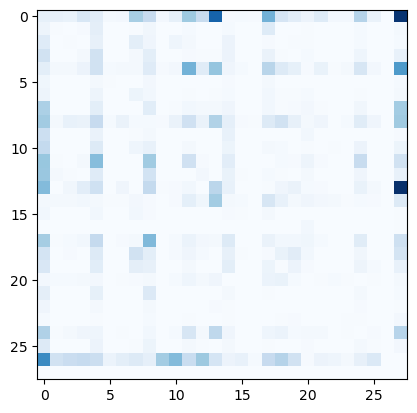

In [21]:
plt.imshow(N, cmap="Blues")

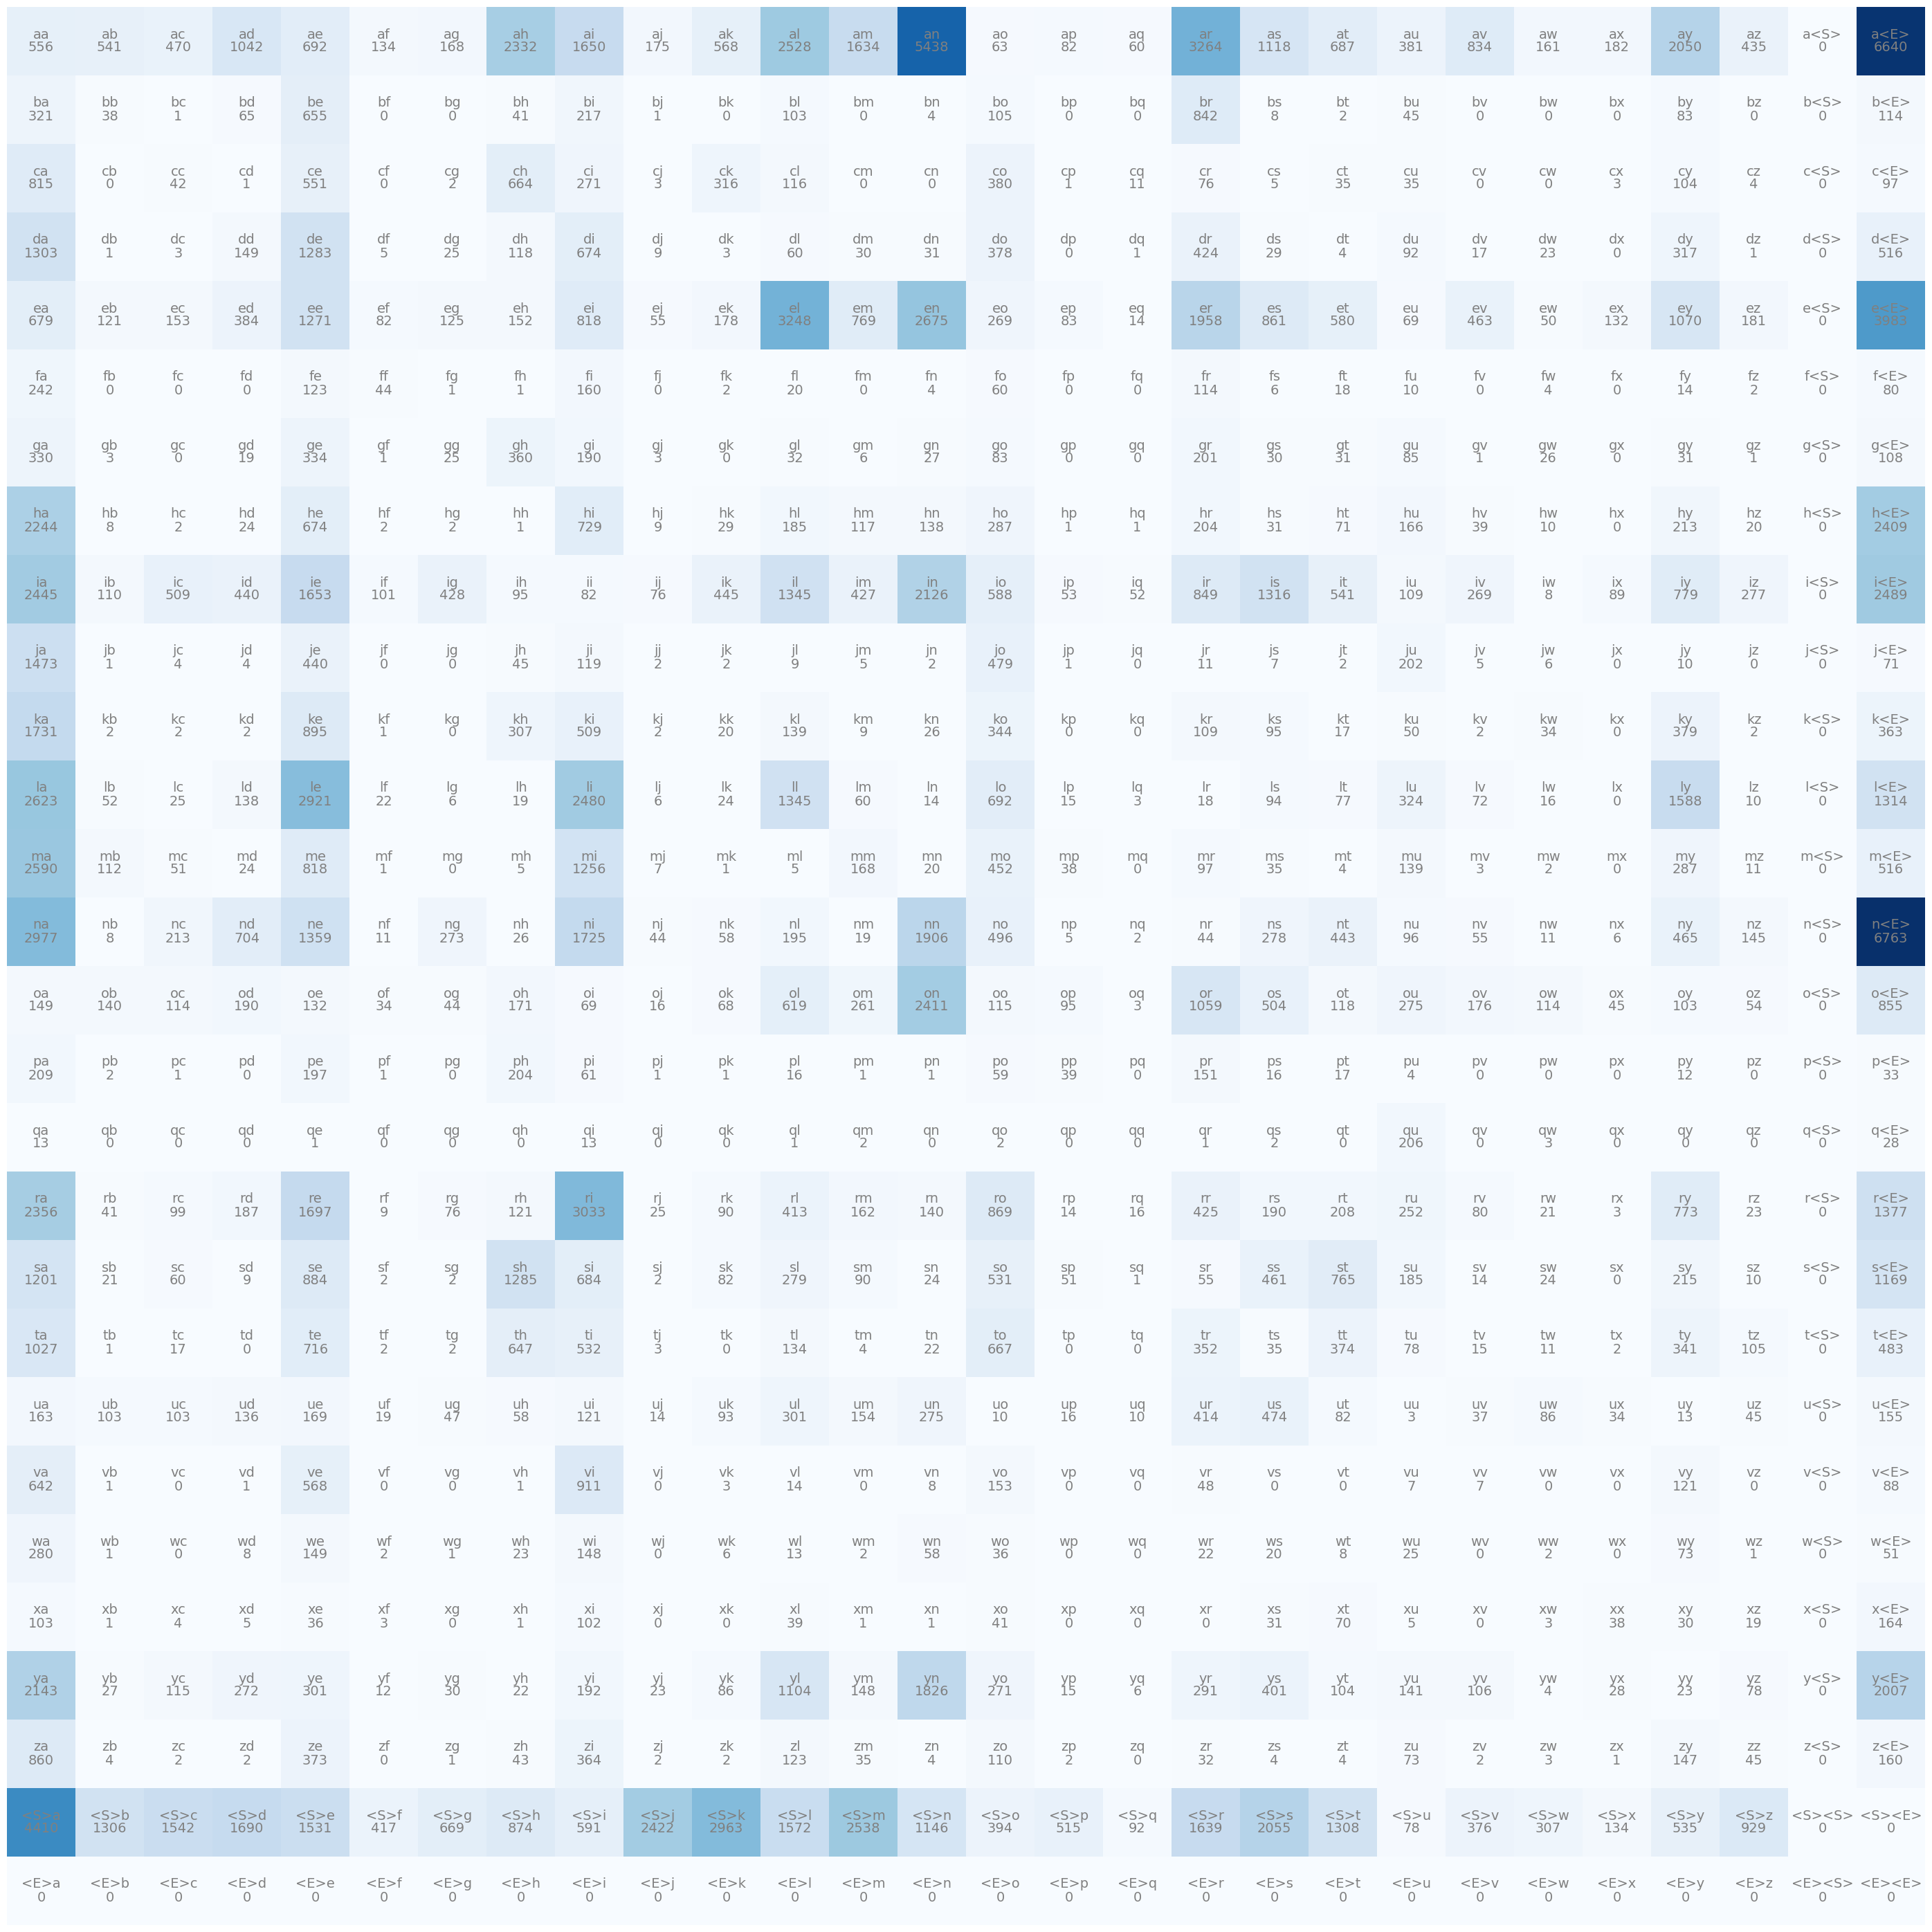

In [22]:
plt.figure(figsize=(36,36))
plt.imshow(N, cmap="Blues") # we plot the array to see the quantities above
# loop on all N array cells
for i in range(28):
    for j in range(28):
        # get the pair corresponding to the cell
        pair = idx_to_char[i] + idx_to_char[j]
        # we write on each cell in the array the name of the pair and the count
        plt.text(j,i,pair,ha="center",va="bottom",color="gray",fontsize=14)
        plt.text(j,i,N[i,j].item(),ha="center",va="top",color="gray",fontsize=14)
plt.axis("off");

- if you look closely on the image, you will see that the entire row of `<E>` is all zeros, and that is because `<E>` is always at the end of the word, so it is never followed by any other character, similarly the entire column of `<S>` is all zeros, and that is because `<S>` is always at the start of the word, so it is never preceded by any other character
- the above array contains all the necessary information to sample from the bi-gram character level language model
    - we are just going to follow the counts in the array to generate new words

In [23]:
# tip: sampling according to a distribution
g = torch.Generator().manual_seed(2147483647) # generator object with a seed
p = torch.tensor([0.6064, 0.3033, 0.0903]) # this is an array of probabilities
torch.multinomial(p, num_samples=10,replacement=True,generator=g)

tensor([1, 1, 1, 0, 0, 2, 2, 0, 1, 1])

- we used a generator object which is a way in pytorch to get consistent results with random functions
    - we create the generator object with a seed
    - we then pass that generator object to any random function (multinomial in our case)
- multinomial is a function that takes a list of probabilities and returns an index according to those probabilities
    - we can specify the number of samples we want to draw from the multinomial distribution
    - we can also specify the replacement=True, which means that we can draw the same index more than once
    - if we draw a lot of samples we expect the indices to be drawn with the same probability as the probabilities we passed to the function
        - meaning that index 0 with large enough samples will occur with distribution of 60% (as it had 60% chance of being drawn)and index 1 with 30, index 2 with 10% 

### Sampling from the bi-gram language model

In [24]:
N[26,:] # this will get us the counts of all characters following <S> in the dataset

tensor([4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963, 1572,
        2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,  134,
         535,  929,    0,    0], dtype=torch.int32)

In [25]:
# to sample the first character in the word, let's check the 26th row (that corresponds to <S> and what comes after it), basically <s>-char pairs
p = N[26].float() # so that we can divide it by the sum and get probabilities with decimals
p /= p.sum() # convert the counts to probabilities in order to sample from it
p

tensor([0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273, 0.0184,
        0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029, 0.0512,
        0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290, 0.0000,
        0.0000])

In [26]:
g = torch.Generator().manual_seed(2147483647)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
idx_to_char[idx]

'k'

- so k is was sampled as a starting character (it is not the letter with the maximum distribution but it was the one that was drawn)
- the next thing to do now is to look for the row of k in the matrix N, and sample from the distribution of the characters that are likely to follow k
- and so on till we reach the end of the word (till we sample the character `<E>`)

In [27]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    word = []
    idx = 26 # the start idx will be of the row of <S>
    while True:
        p = N[idx].float()
        # convert the counts to probabilities 
        p /= p.sum()
        # sample from these probabilities the next idx
        # # in untrained model, are characters are equally likely to come next 
        # p - torch.ones(28) / p.sum()
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if idx == 27: # if we sampled the end token 
            break
        word.append(idx_to_char[idx])
        
    print("".join(word))

karoene
mi
rie
raryli
be
k
ayias
upid
ha
hi
aremio
bar
cemeniydaecenjose
c
matokoronzabelianownvili
gaeunnka
goutanirin
hra
pheazafi
dellaka


- we can see that the bi-gram model is not really a powerful model as the results are terrible
    - but we know it works because we can replay the p vector with uniform distribution and see the difference (instead of getting the p from the matrix N that tells us the distribution of the next character after the current character, we can get it from a uniform distribution that tells us that all characters are equally likely to come next)
- the reason why this model is so bad is that it is only looking at 2 characters at a time (for the above example `k` or `c` where it generated only one character), it first generated the k or the c while looking at the `<s>` character, and then it generated the `<E>` character while looking at only the k or the c character
    - so it is not looking at where the character is in the word, and it is not looking at the context of the word, it is just looking at the last character that was generated and trying to generate the next character based on that

#### Efficiency tip: Preparing the matrix P in advance 
- instead of fetching a row from the matrix N and then divide by the sum to get the P, we can do that from the beginning and store the P matrix in advance

In [28]:
P = N.float()
P /= N.float().sum(axis = 1, keepdim=True)  # divide each row by its sum (we sum the columns for each row)

In [29]:
# now each row is normalized, and can be interpreted as a probability distribution
P[0].sum()

tensor(1.)

- tip: axis attribute: when we sum a 2D array, we can specify the axis along which we want to sum
    - axis=0 means summing along the rows (when we sum along axis 0, then we will take the 0th dimension -rows- and sum across it), so no longer we have N[i,j] where i goes from 0 to 26 and j goes from 0 to 26, but we have N[1,j] where j goes from 0 to 26,and the rows are summed
        - that is if we make keepdims=True, if we make it False, then it wil further squeeze that dimension and instead of a shape of (1,27) we will get a shape of (27)
    - axis=1 means summing along the columns (when we sum along axis 1, then we will take the 1st dimension -columns- and sum across it), so no longer we have N[i,j] where i goes from 0 to 26 and j goes from 0 to 26, but we have N[i,1] where i goes from 0 to 26,and the columns are summed
        - that is if we make keepdims=True, if we make it False, then it wil further squeeze that dimension and instead of a shape of (27,1) we will get a shape of (27)
    
- keep dims is extremely important, because if we set it to false we will get a shape of (27) instead of (27,1) , and pytorch will consider it (1,27) and it will broadcast it in the wrong dimension and we will get a wrong result
- broadcasting rules
    - each tensor has at least one dimension
    - allign the dimensions of the two tensors on the right on top of each other
    - iterating over the dimension sizes, starting from the right 
    - the dimension sizes must be broadcastable, so  either be 
        - equal, 
        - one of them is 1,  (will be broadcasted to the other)
        - or one of them does not exist (a dimension will be created then will be broadcasted to the other)
- so if we have (27,27) and (27), allign them under each other starting from the right, and we must see that  the first dimension is equal (27 for both of them), the second dimension is 27 above and doesnt exist below, so it is 1, and the result will be (27,27)

- another efficiency tip is that in place operations like p/= p.sum() are faster than p = p/p.sum() because the first one will modify the original tensor, while the second one will create a new tensor and assign it to p

In [30]:
# if we set keepdim=False, this will happen and we get a wrong result
# (27,27)
# (27)
# step 1 allign
# (27,27)
#     27
# step 2: the dimensions must be equal or 1 or doesnt exist, and for the 1 or doesnt exist , broadcast them to be equal
# (27, 27)
# (27, 27)

# if we set keepdim=True, this will happen and we get a correct result
# (27,27)
# (27,1)
# step 1 allign, they are already alligned
# step 2: the dimensions must be equal or 1 or doesnt exist, and for the 1 or doesnt exist , broadcast them to be equal
# (27, 27)
# (27, 27) # so each row is broadcasted along the columns (and this is what we want)

In [31]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    word = []
    idx = 26 # the start idx will be of the row of <S>
    while True:
        # p = N[idx].float()
        # # convert the counts to probabilities 
        # p /= p.sum()
        p = P[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if idx == 27: # if we sampled the end token 
            break
        word.append(idx_to_char[idx])
        
    print("".join(word))

karoene
mi
rie
raryli
be
k
ayias
upid
ha
hi
aremio
bar
cemeniydaecenjose
c
matokoronzabelianownvili
gaeunnka
goutanirin
hra
pheazafi
dellaka


- the parameters in this model are really the matrix N, that  summarises the statistics of the bigram-characters in our dataset
- then we learned how to sample from the model
- all that is left to do is to evaluate the quality of this model 
    - we often want to evaluate the quality of a language model by a single number (how good is it at predicting the training set) in other words **The training loss**

## Evalutating the Language Model (Training Loss)
- we can evaluate now the training loss, and this will tell us the performance of the model using a single number

In [32]:
for w in words[:3]:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1,ch2 in zip(chs,chs[1:]):
        prop = P[char_to_index[ch1],char_to_index[ch2]]
        print(f"{ch1}{ch2}, {prop:.4f}")

<S>e, 0.0478
em, 0.0377
mm, 0.0253
ma, 0.3899
a<E>, 0.1960
<S>o, 0.0123
ol, 0.0780
li, 0.1777
iv, 0.0152
vi, 0.3541
ia, 0.1381
a<E>, 0.1960
<S>a, 0.1377
av, 0.0246
va, 0.2495
a<E>, 0.1960


- in the above code we look at the probability that the model assigns to each pair of **the actual consecutive characters** from the **actual** training set
    - mine: the higher that probability the better the model is doing, because it is saying that the probability of this pair - that actually appeared in the dataset - is high, in other words it assigns high probabilities to the actual next characters in the dataset
        - ideally, if a pair say `<S>` was always followed by `h` in the dataset, then a good model that was trained on the dataset would estimate that the probability of this pair is `1`, which means when we sample from the model, we will always get `h` as a start of the word, therefore modeling the dataset perfectly
        - in contrast, a model that is untrained would always assign equal probability to all the pairs, which is 1/28 = 0.0357, 
    - in other words, what we really want to do is to go through the actual dataset token by token -character by character in our case- and for each next actual character in the dataset, we see the assigned probability to it by the model, the higher that probability for the actual next character in the dataset, the better the model is doing
    - so, what we really want to measure is the probability of the dataset, say for a word `isabella`, $p(isabella) = p(i) * p(s|i) * p(a|is) * p(b|isa) * p(e|isab) * p(l|isabe) * p(l|isabel) * p(a|isabell) * p(<E>|isabella)$, this is called the `liklihood` and we do that for all the examples then sum (it is really telling us about the probability of the entire dataset assigned by the model)
        - mine: but of course since for the bigram model we don't have p(a|is) for example, we only have p(a|s), so for example all of the following will get the same probability $p(a|s): p(a|s), p(a|as), p(a|is), p(a|lis), p(a|elis)$, as it only looks at the last character -which is s in this case- -regardless of whatever came before it- to predict the next character, that is why the bigram model is a weak model
        - the higher this number the better, because it assigns high probability to the actual examples in the dataset
        - mine: we don't know in advance what is the highest number we can get practically, if an `m` was always followed by `a` in the dataset, then the highest practical number we can get is 1, but we know that for different examples `m` is not always followed by `a`, so we only need to know that the higher this number, the better the model is doing at modeling the training set 
    - but since these probabilities are between 0 and 1, the product of these probabilities is a really tiny number and an ugly thing to work with, so we measure the log of the probability of the dataset (instead of the probability itself) and this is called the `log-likelihood` of the dataset, 
        - so we measure 

        $log( p(i) * p(s|i) * p(a|s) * p(b|a) * p(e|l) * p(l|b) * p(l|l) * p(a|l) * p(<E>|a) )$ 
        
        which will become 
        
        $log(p(i)) + log(p(s|i)) + log(p(a|s)) + log(p(b|a)) + log(p(e|l)) + log(p(l|b)) + log(p(l|l)) + log(p(a|l)) + log(p(<E>|a))$

        - also the higher this number the better the model is doing, because log is a monotonic function, and since the log output is between `-inf` and `0` -for the range between 0 and 1 which is the range of the input-, the maximum number that we would possibiliy get for each term is 0 and therefore for the whole dataset when we sum them all up is also 0
    - but since we are dealing with a loss, we will take the negative of the log-likelihood of the dataset, and the lower this number, the better the model is doing (mine: highest now is `inf` and lowest is `0`), and this is called the `training loss`
        
    - last thing that people like to do for convenience, they like to average the loss over the number of examples instead of summing them up

In [33]:
for w in words[:3]:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1,ch2 in zip(chs,chs[1:]):
        prop = P[char_to_index[ch1],char_to_index[ch2]]
        log_prop = torch.log(prop)
        print(f"{ch1}{ch2}, Prob: {prop:.4f}, -ve Log-Prob: {-log_prop:.4f}")

<S>e, Prob: 0.0478, -ve Log-Prob: 3.0408
em, Prob: 0.0377, -ve Log-Prob: 3.2793
mm, Prob: 0.0253, -ve Log-Prob: 3.6772
ma, Prob: 0.3899, -ve Log-Prob: 0.9418
a<E>, Prob: 0.1960, -ve Log-Prob: 1.6299
<S>o, Prob: 0.0123, -ve Log-Prob: 4.3982
ol, Prob: 0.0780, -ve Log-Prob: 2.5508
li, Prob: 0.1777, -ve Log-Prob: 1.7278
iv, Prob: 0.0152, -ve Log-Prob: 4.1867
vi, Prob: 0.3541, -ve Log-Prob: 1.0383
ia, Prob: 0.1381, -ve Log-Prob: 1.9796
a<E>, Prob: 0.1960, -ve Log-Prob: 1.6299
<S>a, Prob: 0.1377, -ve Log-Prob: 1.9829
av, Prob: 0.0246, -ve Log-Prob: 3.7045
va, Prob: 0.2495, -ve Log-Prob: 1.3882
a<E>, Prob: 0.1960, -ve Log-Prob: 1.6299


- notice that the higher the probability assigned to the actual next token -character- in the dataset, the lower the negative log likelihood, and the better the model is doing

In [34]:
log_liklihood = 0.0
n = 0
for w in words:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1,ch2 in zip(chs,chs[1:]):
        prop = P[char_to_index[ch1],char_to_index[ch2]] # get the probability of the next actual character from the mode, given the current character
        log_prop = torch.log(prop) # get the log of that probability
        log_liklihood += log_prop # accumulate the log probabilities
        n += 1
        #print(f"{ch1}{ch2}, {log_prop:.4f}")

print(f"Log liklihood {log_liklihood}")
print(f"Negative log liklihood {-log_liklihood}")
print(f"Average negative log liklihood (cost: Average of losses) {-log_liklihood/n}")

Log liklihood -559891.75
Negative log liklihood 559891.75
Average negative log liklihood (cost: Average of losses) 2.454094171524048


- in summary
- our goal is to maximize liklihood, which is the product of all the probabilities -of the actual examples in the dataset- assigned by the model
    - and we want to maximize this liklihood w.r.t the parameters of the model (which are explicit in here as the matrix N, but later in NN these numbers in the matrix will be calculated by the NN)
    - and we want to change and tune these parameters to maximize the liklihood
- maximizing the liklihood is equivalent to maximizing the log-liklihood, because log is a monotonic function (monotonic means that if x>y then log(x)>log(y))
    - think of the log as scaling, instead of dealing with very small numbers between 0 and 1, we deal with numbers between -inf and 0
- and maximizing the log-liklihood is equivalent to minimizing the negative log-liklihood
    - mine: the numbers are now between inf and 0, and the lower the number the better the model is doing
- and in practice, we minimize the average negative log-liklihood (mine: so that the loss is irrelevant to the dataset size), and this summarizes the performance of the model on the training set, the lower it is the better the model is doing, and the min it can be is 0

## Using language model to estimate the probability of a word
- we can actually use language models not just for sampling but also to estimate the probability of a word (how likely is it to appear)
    - since we deal with character-level language model, we can estimate the probability of a word by multiplying the probabilities of the characters in the word
        - mine: but later for word-level language models, we can estimate the probability of an entire sentence by multiplying the probabilities of the words in the sentence

In [35]:
log_liklihood = 0.0
n = 0
for w in ["yousef"]:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1,ch2 in zip(chs,chs[1:]):
        log_prop = torch.log(P[char_to_index[ch1],char_to_index[ch2]])
        log_liklihood += log_prop
        n += 1
        print(f"{ch1}{ch2}, {log_prop:.4f}")

print(f"Log liklihood {log_liklihood}")
print(f"Negative log liklihood {-log_liklihood}")
print(f"Average negative log liklihood {-log_liklihood/n}")

<S>y, -4.0923
yo, -3.5856
ou, -3.3621
us, -1.8892
se, -2.2159
ef, -5.5177
f<E>, -2.4259
Log liklihood -23.088651657104492
Negative log liklihood 23.088651657104492
Average negative log liklihood 3.2983787059783936


- we see that these words are unlikely to appear (at least less than the names of the dataset)
- notice what happens when we append `j` to `yousef`
    - from the matrix N,we see that `fj` pair appeared 0 times in the dataset

In [36]:
log_liklihood = 0.0
n = 0
for w in ["yousefj"]:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1,ch2 in zip(chs,chs[1:]):
        log_prop = torch.log(P[char_to_index[ch1],char_to_index[ch2]])
        log_liklihood += log_prop
        n += 1
        print(f"{ch1}{ch2}, {log_prop:.4f}")

print(f"Log liklihood {log_liklihood}")
print(f"Negative log liklihood {-log_liklihood}")
print(f"Average negative log liklihood {-log_liklihood/n}")

<S>y, -4.0923
yo, -3.5856
ou, -3.3621
us, -1.8892
se, -2.2159
ef, -5.5177
fj, -inf
j<E>, -3.7098
Log liklihood -inf
Negative log liklihood inf
Average negative log liklihood inf


- we see that its component had loss inf and therefore made the loss for the entire dataset inf because we sum up these terms
- people don't like this too much, and to fix it they do what is called model smoothing
    - we will add a small number `1` to all the counts in the matrix N, and this will make the loss finite (this is called adding `fake counts`)
    - then we recaulculate the matrix P and the loss
    - the larger the number we add, the smoother the model will be, smoother meaning more towards uniform distribution (for example if we add say 1000000 to the array, the current counts will be negligible compared to the added counts, and the model will be very close to uniform distribution)
- this will cause no probabilities to be zero in the matrix p, and might change the generation a little bit

In [37]:
N += 1
P = N.float()
P /= N.float().sum(axis = 1, keepdim=True) 

In [38]:
log_liklihood = 0.0
n = 0
for w in ["yousefj"]:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1,ch2 in zip(chs,chs[1:]):
        prop = P[char_to_index[ch1],char_to_index[ch2]]
        log_prop = torch.log(prop)
        log_liklihood += log_prop
        n += 1
        print(f"{ch1}{ch2}, {prop:.4f} {log_prop:.4f}")

print(f"Log liklihood {log_liklihood}")
print(f"Negative log liklihood {-log_liklihood}")
print(f"Average negative log liklihood {-log_liklihood/n}")

<S>y, 0.0167 -4.0913
yo, 0.0277 -3.5847
ou, 0.0347 -3.3620
us, 0.1502 -1.8960
se, 0.1088 -2.2182
ef, 0.0041 -5.5069
fj, 0.0011 -6.8384
j<E>, 0.0246 -3.7054
Log liklihood -31.20298194885254
Negative log liklihood 31.20298194885254
Average negative log liklihood 3.9003727436065674


- the propability o `fj` rose from 0 to 0.0011 (very small probability)

## 1-b: alternative approach to Bi-gram (Neural Network approach)

- we will use a NN approach to model the bi-gram language model
    - so, we will have a weights matrix (instead of the matrix N) that will be the parameters of the model
    - we will also create a dataset of X -> Y mapping (that is basically all the subsequences of 2 characters in the dataset)
        - and we will use the character indices as the model expects numbers (mine: in general we need to use the indices of the tokens)
    - then we will optimize the parameters of the model w.r.t the negative log-likelihood of the dataset

- so this is basically the same but using a neural network approach(where we have a neural net and x -> y mapping and loss function that measures the performance of the model on the dataset) and we will optimize the parameters of the model to minimize the loss

- the NN will recieve a single character as an input, and it will output a probability distribution over the next character in the sequence 
    - and we will evaluate and optimise the parameters of the NN because we now have a loss function `the negative log-likelihood` 
        - we will use the actual next characters as labels and the output of the NN as predictions, and we will evalualte the loss and backpropagate it to update the parameters of the NN 

### Prepare the dataset of all the bigrams for the NN

In [39]:
Xs, Ys = [], []
for w in words[:1]:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1,ch2 in zip(chs,chs[1:]):
        Xs.append(char_to_index[ch1])
        Ys.append(char_to_index[ch2])
        print(ch1, ch2)

Xs = torch.tensor(Xs)
Ys = torch.tensor(Ys)

<S> e
e m
m m
m a
a <E>


In [40]:
Xs, Ys # contains the indicies of the tokens (characters) i the vocabulary

(tensor([26,  4, 12, 12,  0]), tensor([ 4, 12, 12,  0, 27]))

- we notice that there are 5 different examples in `<s>emma<e>`
    - when `<s>` is an input (26), we want `e` (4) to have a high probability
    - when the input of the neural network is 4 `e`, we want 12 `m` to have a high probability
    - when the input of the neural network is 12 `m`, we want 12 `m` to have a high probability 
    - when the input of the neural network is 12 `m`, we want 0 `<e>` to have a high probability

and so on in a way that maximizes the probability of all dataset as best as possible, (minimize the average negative log-likelihood)

- tip: torch.tensor vs torch.Tensor
    - torch.tensor infers the dtype from the input, while torch.Tensor uses the floattensor
    - it is advised that we use torch.tensor, since we want integers

- encoding the integers 
    - these examples right now are integers with no meaning (they are just the indices of the characters in the dataset)
    - we could feed the NN these integers directly, but we don't do that because higher numbers will indicate higher importance (as the weights interact multiplicatively with the inputs)
        - but basically all of them are equally important
    - instead we use one-hot encoding for the characters 

In [41]:
import torch.nn.functional as F

In [42]:
x_enc = F.one_hot(Xs, num_classes=28).float()

In [44]:
x_enc

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [43]:
x_enc.shape

torch.Size([5, 28])

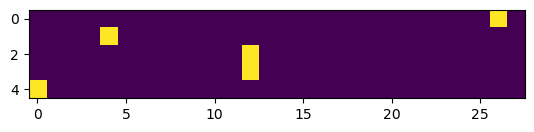

In [45]:
plt.imshow(x_enc)

- the appropiate bit is turned on and the rest are zeros

In [46]:
x_enc.dtype # we usually want inputs to be float that can take on various values

torch.float32

- when we plug numbers into the neural network, we want them to be floating point numbers that can take on various values and decimals

- always watch out for the shapes of the tensors, and the dtypes

- random distribution 
![Image Description](https://stats.libretexts.org/@api/deki/files/10486/standardNormal-eps-converted-to.png?revision=1)

we see that most numbers drawn will be between -1 and 1

In [47]:
W = torch.randn((28,1))
W

tensor([[ 0.3571],
        [-1.2057],
        [ 0.7615],
        [-0.6429],
        [ 1.9020],
        [ 0.3654],
        [ 0.6005],
        [ 0.9061],
        [ 0.5442],
        [ 0.8561],
        [ 0.6043],
        [ 1.7120],
        [-1.3412],
        [ 1.0251],
        [-1.4813],
        [-0.0507],
        [ 0.5363],
        [-0.4010],
        [ 1.5003],
        [-0.6851],
        [ 2.1262],
        [-2.2394],
        [ 1.2900],
        [ 0.7511],
        [-0.0787],
        [-0.0299],
        [-0.4574],
        [-1.5222]])

In [48]:
x_enc @ W # @ is a matrix multiplication operator in pytorch,  5(m)x28 * 28x1(neurons=classes) = 5x1

tensor([[-0.4574],
        [ 1.9020],
        [-1.3412],
        [-1.3412],
        [ 0.3571]])

- the above is the output of one neuron for the 5 examples
    - we will use 28 neurons (one for each character), and to use the softmax so that we produce the probability distribution of the next character for all the examples at once

In [49]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((28,28),generator=g)
z = x_enc @ W 

In [51]:
z = x_enc @ W 
z.shape # (m,28) @ (28 features,28 neurons=characters) -> (m,28)

torch.Size([5, 28])

In [52]:
z[3,13]

tensor(0.6849)

- what does z tell us? it tells us for every one in the 28 neurons that we created, what is the firing rate of that neuron (how much it is firing) for every example
    - for example z[3,13] tells us the firing rate of the 13th neuron looking at the 3rd example (by a dot product between the 3rd example and the 13th neuron weights -13 column in the weight matrix-)
- by using matrix multiplication, we can efficiently evaluate the dot product between the each example and the weights of the neurons in parallel

- the architecture so far is input layer of 28 neurons, and one hidden layer of 28 neurons, no bias or activation functions (a linear layer)

In [53]:
z

tensor([[-1.1002,  0.9138,  1.4855,  0.3997,  0.3542, -0.9169, -0.9531,  0.2753,
          0.9220,  0.6069, -0.8678,  0.5952,  0.7896, -0.6847, -0.4240,  1.7054,
          0.8627, -0.4551,  0.3854,  0.2925,  0.1852,  0.0560, -0.4791, -1.1102,
         -0.2321,  0.3832, -0.1267,  0.7101],
        [ 0.1755, -2.2901, -0.7093, -0.2928, -2.1803,  0.0793,  0.9019,  1.2028,
         -0.5614, -0.1375, -0.1380, -2.0977, -0.7924,  0.6069, -1.4777, -0.5103,
          0.5642,  0.9684, -0.3111, -0.3060, -1.7495, -1.6335,  0.3876,  0.4724,
          1.4830,  0.3175,  1.0588,  2.3982],
        [ 0.6361,  0.1911,  0.7548,  0.4054,  2.2565,  1.3655, -0.5619, -0.3042,
          0.2989,  1.8784,  0.5596,  1.3388,  0.4161,  0.6849, -0.1479,  0.1936,
          1.0532,  0.6339,  0.2579,  0.9641, -0.2485,  0.0248, -0.0304,  1.5622,
         -0.4485, -1.2345,  1.1220, -0.6738],
        [ 0.6361,  0.1911,  0.7548,  0.4054,  2.2565,  1.3655, -0.5619, -0.3042,
          0.2989,  1.8784,  0.5596,  1.3388,  0.4161

- we see that the Zs are some +ve and some -ve numbers , we will interpret them (these logits) as the log counts, so to get the counts we will exponentiate them and divide by the sum to get the probabilities
-  we want to convert them to probabilities (that represent the distribution of the next character)
    - we can do that by using the softmax function, a softmax takes the outputs of the NN it will convert them to probabilities (it is like a normalization function)
    - we can put it on top of any linear layer inside the NN to make it output probabilities

In [56]:
z.exp()

tensor([[ 0.3328,  2.4938,  4.4170,  1.4913,  1.4251,  0.3998,  0.3855,  1.3169,
          2.5143,  1.8348,  0.4199,  1.8133,  2.2024,  0.5042,  0.6544,  5.5034,
          2.3696,  0.6344,  1.4702,  1.3397,  1.2034,  1.0576,  0.6194,  0.3295,
          0.7929,  1.4670,  0.8810,  2.0342],
        [ 1.1918,  0.1013,  0.4920,  0.7461,  0.1130,  1.0825,  2.4642,  3.3294,
          0.5704,  0.8715,  0.8711,  0.1227,  0.4528,  1.8347,  0.2282,  0.6003,
          1.7581,  2.6337,  0.7326,  0.7364,  0.1739,  0.1952,  1.4735,  1.6038,
          4.4060,  1.3737,  2.8830, 11.0032],
        [ 1.8892,  1.2106,  2.1271,  1.4999,  9.5496,  3.9176,  0.5701,  0.7377,
          1.3484,  6.5432,  1.7499,  3.8143,  1.5160,  1.9836,  0.8625,  1.2136,
          2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,  4.7691,
          0.6386,  0.2910,  3.0710,  0.5098],
        [ 1.8892,  1.2106,  2.1271,  1.4999,  9.5496,  3.9176,  0.5701,  0.7377,
          1.3484,  6.5432,  1.7499,  3.8143,  1.5160

In [57]:
a = z.exp() / z.exp().sum(axis=1, keepdim=True) # get the probabiilities 
a

tensor([[0.0079, 0.0595, 0.1054, 0.0356, 0.0340, 0.0095, 0.0092, 0.0314, 0.0600,
         0.0438, 0.0100, 0.0433, 0.0526, 0.0120, 0.0156, 0.1313, 0.0565, 0.0151,
         0.0351, 0.0320, 0.0287, 0.0252, 0.0148, 0.0079, 0.0189, 0.0350, 0.0210,
         0.0485],
        [0.0271, 0.0023, 0.0112, 0.0169, 0.0026, 0.0246, 0.0559, 0.0756, 0.0130,
         0.0198, 0.0198, 0.0028, 0.0103, 0.0417, 0.0052, 0.0136, 0.0399, 0.0598,
         0.0166, 0.0167, 0.0039, 0.0044, 0.0335, 0.0364, 0.1000, 0.0312, 0.0655,
         0.2498],
        [0.0308, 0.0198, 0.0347, 0.0245, 0.1559, 0.0640, 0.0093, 0.0120, 0.0220,
         0.1068, 0.0286, 0.0623, 0.0247, 0.0324, 0.0141, 0.0198, 0.0468, 0.0308,
         0.0211, 0.0428, 0.0127, 0.0167, 0.0158, 0.0779, 0.0104, 0.0048, 0.0501,
         0.0083],
        [0.0308, 0.0198, 0.0347, 0.0245, 0.1559, 0.0640, 0.0093, 0.0120, 0.0220,
         0.1068, 0.0286, 0.0623, 0.0247, 0.0324, 0.0141, 0.0198, 0.0468, 0.0308,
         0.0211, 0.0428, 0.0127, 0.0167, 0.0158, 0.0779

In [58]:
a[0,:].sum() # each row will sum to one (probabilities) that represent the distribution of the next character 

tensor(1.)

- for every one of our 5 examples, we have a row that came out of the nural network that represents the probability distributions of the next character 
    - we can use backpropagation to update the weights of the neurons to make the probability distribution of the next character more similar to the actual distribution of the next character for all the dataset

In [59]:
nlls = torch.zeros(5)
for i in range(5):
    x = Xs[i].item()
    y = Ys[i].item()
    print("---------------")
    print(f"Bigram exmple {i+1}: {idx_to_char[x]}-{idx_to_char[y]} indicies {x}, {y}")
    print(f"input to the neural net {x}")
    print(f"Output probabilities from the neural net: {a[i]}")
    print(f"Label  (actual next character): {y}")
    p = a[i,y]
    print(f"probability assigned by the NN to the actual next character: {p.item()}, {p.item()*100:.2f}%")
    logp = torch.log(p)
    print(f"Log liklihood: {logp.item()}")
    nll = -logp
    print(f"Negative log liklihood (loss): {nll.item()}")
    nlls[i] = nll

print("========================")
print(f"Avergae negative log liklihood (cost): {nlls.mean().item()}")

---------------
Bigram exmple 1: <S>-e indicies 26, 4
input to the neural net 26
Output probabilities from the neural net: tensor([0.0079, 0.0595, 0.1054, 0.0356, 0.0340, 0.0095, 0.0092, 0.0314, 0.0600,
        0.0438, 0.0100, 0.0433, 0.0526, 0.0120, 0.0156, 0.1313, 0.0565, 0.0151,
        0.0351, 0.0320, 0.0287, 0.0252, 0.0148, 0.0079, 0.0189, 0.0350, 0.0210,
        0.0485])
Label  (actual next character): 4
probability assigned by the NN to the actual next character: 0.03400470316410065, 3.40%
Log liklihood: -3.381256341934204
Negative log liklihood (loss): 3.381256341934204
---------------
Bigram exmple 2: e-m indicies 4, 12
input to the neural net 4
Output probabilities from the neural net: tensor([0.0271, 0.0023, 0.0112, 0.0169, 0.0026, 0.0246, 0.0559, 0.0756, 0.0130,
        0.0198, 0.0198, 0.0028, 0.0103, 0.0417, 0.0052, 0.0136, 0.0399, 0.0598,
        0.0166, 0.0167, 0.0039, 0.0044, 0.0335, 0.0364, 0.1000, 0.0312, 0.0655,
        0.2498])
Label  (actual next character): 12
pro

- notice that the probabilities assigned to the actual next characters are very low initially (the highest is 3%), therefore the loss is very high 

### Train the NN

- we start with initial W, and we will update it to minimize the loss using gradient-based optimization

#### Prepare the dataset

In [60]:
Xs, Ys = [], []
for w in words:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1,ch2 in zip(chs,chs[1:]):
        Xs.append(char_to_index[ch1])
        Ys.append(char_to_index[ch2])

Xs = torch.tensor(Xs)
Ys = torch.tensor(Ys)

In [63]:
x_enc = F.one_hot(Xs, num_classes=28).float()

In [64]:
x_enc.shape

torch.Size([228146, 28])

#### Initialize the weights

In [65]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((28,28),generator=g, requires_grad=True) # requires grad = True is basicallyy telling pytorch that we are interested in calculating its gradient shape (28 features, 28 neurons=classes), 

In [95]:
epochs = 100

for i in range(epochs):        
    # forward prop 
    z = x_enc @ W 
    a = z.exp() / z.exp().sum(axis=1, keepdim=True)
    loss = -a[torch.arange(len(Xs)),Ys].log().mean() # we pick the probability of actual next character for all examples (we index the rows incrementally 0,1,2,3 and so on, and the columns using the Ys -next character-) , then we take the log (log liklihood), then -ve (negative log likelihood) then sum and divide by the number of the examples (mean)

    # backward prop
    W.grad = None  # set the gradients to 0
    loss.backward()


    # update the parameters
    W.data -= 50 * W.grad

print(loss.item())

2.4723427295684814
2.472151517868042
2.471964120864868
2.4717800617218018
2.471599817276001
2.4714224338531494
2.4712486267089844
2.4710779190063477
2.4709105491638184
2.4707460403442383
2.4705846309661865
2.470425844192505
2.4702701568603516
2.4701173305511475
2.4699668884277344
2.4698193073272705
2.4696741104125977
2.469531536102295
2.469391345977783
2.4692535400390625
2.4691178798675537
2.468985080718994
2.468853712081909
2.4687254428863525
2.4685988426208496
2.4684741497039795
2.468351364135742
2.468231201171875
2.4681124687194824
2.467996120452881
2.467881202697754
2.4677681922912598
2.4676568508148193
2.467547655105591
2.467439651489258
2.4673333168029785
2.4672293663024902
2.4671263694763184
2.4670250415802
2.4669246673583984
2.4668266773223877
2.4667296409606934
2.4666342735290527
2.4665403366088867
2.466447353363037
2.4663562774658203
2.46626615524292
2.466177463531494
2.466089963912964
2.466003656387329
2.465918779373169
2.465834617614746
2.465752124786377
2.465670585632324
2

- remember that lower loss means higher probability assigned to the actual next characters in the dataset

- in the above cell we wrote the forward pass 
    - which is a linear layer followed by a softmax activation, to interpret the output of the linear layer as a probability distribution
    - we calculated the loss, by picking the propability outputed from the model of the actual next character for each example, and then we took the negative log of that probability, and then we averaged that over the number of examples
- then we calculated the backward pass
    - we first set the previous gradients to zero, and we did that using tensor.grad = None, and this is a way to do that in pytorch (an efficient way) and pytorch will interpret it as the lack of gradients which zeros

- the loss we expect is similar to the one we got by counting, because fundamentally we are not taking any addditional information, the only difference is in the approach
    - instead of doing so by counting and normalizing, we are doing it using gradient-based learning 
    - the gradient-based learning might reach a better loss only if the original approach didn't exploit that same information well

- but the advatage that NNs have over the original intuitive approach is that they are extremely flexible, we can expand this approach and complexify the neural network to capture more complex patterns in the data
    - and the flexibility is that the only thing that we will change is how we get from the data to the logits of the NN, and the rest is literally the same , we will always get logits then a softmax to convert them to probabilities then a loss function (average negative log-likelihood -average negative log of the model probabilities of the actual next characters-)
    - and we will indeed complexify the model all the way up to the transformer model (none of the above code will change except the way we will do forward pass to get from the data to the logits)
    - unlike the intuitive bigram model which would be very complicated to scale it up, and the tables would get too large if we counted more complicated patterns (2 or 3 prebious characters for example)

- analogy 
- notice that xenc is made up of one hot vectors, so when we multiply it by the weights matrix (where the neurons are stacked up in columns), say if the 5th dimension of the ont-hot is 1, it will be multiplied with the 5th dimension of all the neurons, and the logits for that example are simply the 5th row of W (because matrix multiplication will multiply the 1 at 5th dimension with the weights at the 5th row for each column or neuron), and then we apply softmax to that row in order to get the probability, then access the probability of the actual next character in that row then take the negative log of that probability, and then average that over all the examples
- that is exactly what happened in the intuitive approach, we had a matrix N, and we took the character and indexed into the corresponding row of the matrix n, and used the next character to index into the corresponding column of that row in N, then exponentiated and normalised to get the probability
- so, in both P and A, the first character is used to access the row of that character that contains the probability distribution of the next characters, and the next character is used to access the column of that row to get the probability of that character
- the only difference is that N was filled in by counting, where in W we initialized it randomly and then we let the loss guide us to the exact same array

### Smoothing in the gradient-based framework (regularization)
- it turns out that the gradient-based framework has an equivalent to the smoothing that we did in the intuitive approach
    - if Ws are all zeros, then the logits will be all zeros (z = xenc @ W), and the when we exponentiate they will all be 1, and when we normalise they will all be 1/28, so the probabilities will be uniform (smoother) mine: this is in general for all multi-class classification problems
    - so, trying to incentivize W towards zeros is basically equivalent to smoothing the model, and the more we incentivize W towards zeros, the more smoothing we will get, and this is **called regularization**
    - in regularization , we simply penalize the Ws to get samll values that are close to zero (will make the W values samller)

In [96]:
l2_loss = 0.01 * (W**2).mean()
l2_loss

tensor(0.0218, grad_fn=<MulBackward0>)

- we simmply summed the values of W (or take their average so that the regularization loss doesn't scale up with larger parameters) as the regularization loss, but we squared before it so that the negative values don't cancel the positive values, and we multiplied by a small number to control the strength of the regularization
    - we will achieve 0 regularization loss if the values of W are exactly zeros
    - we can add that to the actual loss in the training loop 
- now the optimisation has 2 components, not only it will try to make all the probabilities work out, but it will also try to make the Ws small (close to zeros) depending on what term is greater it will emphasize more on it 
    - so we have 2 opjectives, one that tries to make the Ws smaller and therefore the probabilities closer to the uniform distribution for all next characters, and the other tries to make the probabilities closer to the actual distribution of the next characters in the dataset, the strength of regularization `lambda` is equivalent to the counts we added to the matrix in the 1st approach 

### Sample from that NN model

In [98]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    word = []
    idx = torch.tensor([26]) # the start idx will be of the row of <S>
    while True:
        # get the logits from the model
        logit = F.one_hot(idx, num_classes=28).float() @ W # 1x28 @ 28x28 -> 1x28
        # convert the logits to probabilities
        p = logit.exp() / logit.exp().sum(axis=1, keepdim=True) # 1(m)x28  
        #p = P[idx]
        # sample from these probabilities the next idx
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).squeeze(1) # 1(m)x1 -> 1
        if idx == 27: # if we sampled the end token 
            break
        word.append(idx_to_char[idx.item()])
        
    print("".join(word))

karoene
mi
rie
raryli
be
k
ayias
upid
ha
hi
aremio
bar
cemeniydaecenjosx
c
matokoronzabelianownvili
gaeunnka
goutanirin
hra
pheazafi
dellaka


- the only difference is that we are using the NN to get the probabilities instead of the matrix N, and we are using the same sampling technique as before
- we got the identical result as the 1st approach, and that is because the NN we chose is identical to the matrix N

## Conclusion
- we saw the bigram character-level language model, we trained it in 2 different ways, we saw how to sample from the model, calculate the probability of a word, and evaluate the model using the negative log liklihood loss, and we saw how to regularize the model
- in the following notebooks we will complexify the NN, by getting more characters before calculating the distribution of the next character, and the NN will still output the exact same thing, and everything stays identical (in terms of getting the logits then cnverting them to probabilities using softmax then getting the probability of the actual next character and taking the -log of that as the loss) except how do we calculate these logits (we will complexify the NN up to the transformer model) and this shows how scalable the NNs are scalable
    - unlike the intuitive approach, if we are to take for example 2 characters as a context, the table will have 28^2 = 784 entries, and if we take 3 characters as a context, the table will have 28^3 = 21952 entries, and so on, and this is not scalable (`the table grows exponentially with the length of the context`), and this is why we use NNs